### Capstone Presentation

__First:__ Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

__Second:__ Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

__Third:__ Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

__Deliverable:__ Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:
- A specified research question your model addresses
- How you chose your model specification and what alternatives you compared it to
- The practical uses of your model for an audience of interest
- Any weak points or shortcomings of your model

# 1. Dataset: Ames, Iowa Housing Market Data

## 1.1 Dataset background

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import datetime as dt
import time
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

#display options
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='darkgrid', palette='muted', font_scale=1.3)

## 1.2 Upload Data

In [2]:
train_raw = pd.read_csv('train.csv')
train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_raw.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
train_raw.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1.3 Choose Target Outcome

- Predict timeframe with regards to the recession
- Dates for the recession: Dec 2007 - June 2009 [source](https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States)
- Binary classification: 0 = not recession, 1 = recession
- Multiclass: 0 = before recession, 1 = recession, 2 = after recession

# 2. Data Cleaning & Exploration

## 2.1 Basic Cleaning

In [5]:
#set df to manipulate, leave raw accessible
train = train_raw.copy()

#lowercase column names
train.columns = [x.lower() for x in train.columns]

#find object datatypes and strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

## 2.2 Missingness

### See whats missing

In [6]:
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,1453
1,miscfeature,1406
2,alley,1369
3,fence,1179
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


### Handle missingness
__Drops:__
- Only one electrical value is missing, drop row

__Categorical:__ classes that categorical variables can take are found in the file 'data_description.txt'. The NA class indicates the property does not have any of the feature in question, fill NAs with relevant text for dummy variables
- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type

__Continuous:__ fill NAs with 0
- lotfrontage: linear feet of street connected to property
- garageyrblt: year garage was built
- masvnrarea: masonry veneer area in square feet

In [7]:
#drop
train.dropna(subset=['electrical'], inplace=True)

#categorical
train['poolqc'].fillna('no_pool', inplace=True)
train['miscfeature'].fillna('no_miscfeat', inplace=True)
train['alley'].fillna('no_access', inplace=True)
train['fence'].fillna('no_fence', inplace=True)
train['fireplacequ'].fillna('no_fireplace', inplace=True)
train['garagecond'].fillna('no_garage', inplace=True)
train['garagetype'].fillna('no_garage', inplace=True)
train['garagefinish'].fillna('no_garage', inplace=True)
train['garagequal'].fillna('no_garage', inplace=True)
train['bsmtexposure'].fillna('no_bsmt', inplace=True)
train['bsmtfintype1'].fillna('no_bsmt', inplace=True)
train['bsmtfintype2'].fillna('no_bsmt', inplace=True)
train['bsmtcond'].fillna('no_bsmt', inplace=True)
train['bsmtqual'].fillna('no_bsmt', inplace=True)
train['masvnrtype'].fillna('no_masvnr', inplace=True)

#continuous
train['lotfrontage'].fillna(0, inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

## 2.3 Target Outcome
- Create more date/time columns to explore
- Create classification

__Three Classes:__
- 0 = pre recession (before Dec 2007)
- 1 = during recession (Dec 2007 - June 2009)
- 2 = post recession (July 09 and after)

In [8]:
train['mosold'] = train['mosold'].apply('{:0>2}'.format)
train['yrmo_sold'] = train.yrsold.astype(
    str).str.cat(train.mosold.astype(str)).astype(int)

In [9]:
#functions to help with new columns

#create class column and label
def label_class (i):
    if i['yrmo_sold'] <= 200711:
        return 0
    if 200712 <= i['yrmo_sold'] <= 200906:
        return 1
    if i['yrmo_sold'] >= 200907:
        return 2
    
#create quarter column and label
def label_quarter (i):
    if 1 <= i['mosold'] <= 3:
        return 'q1'
    if 4 <= i['mosold'] <= 6:
        return 'q2'
    if 7 <= i['mosold'] <= 9:
        return 'q3'
    if 10 <= i['mosold'] <=12:
        return 'q4'

In [10]:
#quarter sold column
#convert back for conditional statement in function
train['mosold'] = train['mosold'].astype(int)
train['qtr_sold'] = train.apply(label_quarter, axis=1)

#yearquarter_sold column
train['yrqtr_sold'] = train.yrsold.astype(
    str).str.cat(train.qtr_sold.astype(str))

#class column
train['class_mult'] = train.apply(label_class, axis=1)

In [48]:
#better x labels
xlabels_yrmo = pd.date_range(start='2006-01-01', periods=55, freq='M')
#xlabels_yrmo = xlabels_yrmo.to_pydatetime()
#xlabels_yrmo = xlabels_yrmo.dt.normalize()
xlabels_yrmo = pd.Series(xlabels_yrmo)
xlabels_yrmo = xlabels_yrmo.dt.date
#xlabels_yrmo = xlabels_yrmo.apply(lambda x: x.strftime('%Y-%m-%d'))

### Data Exploration

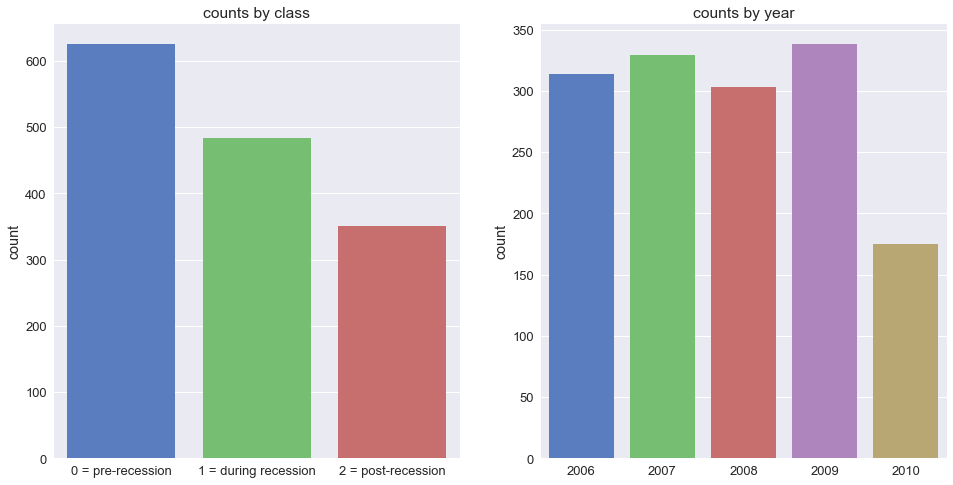

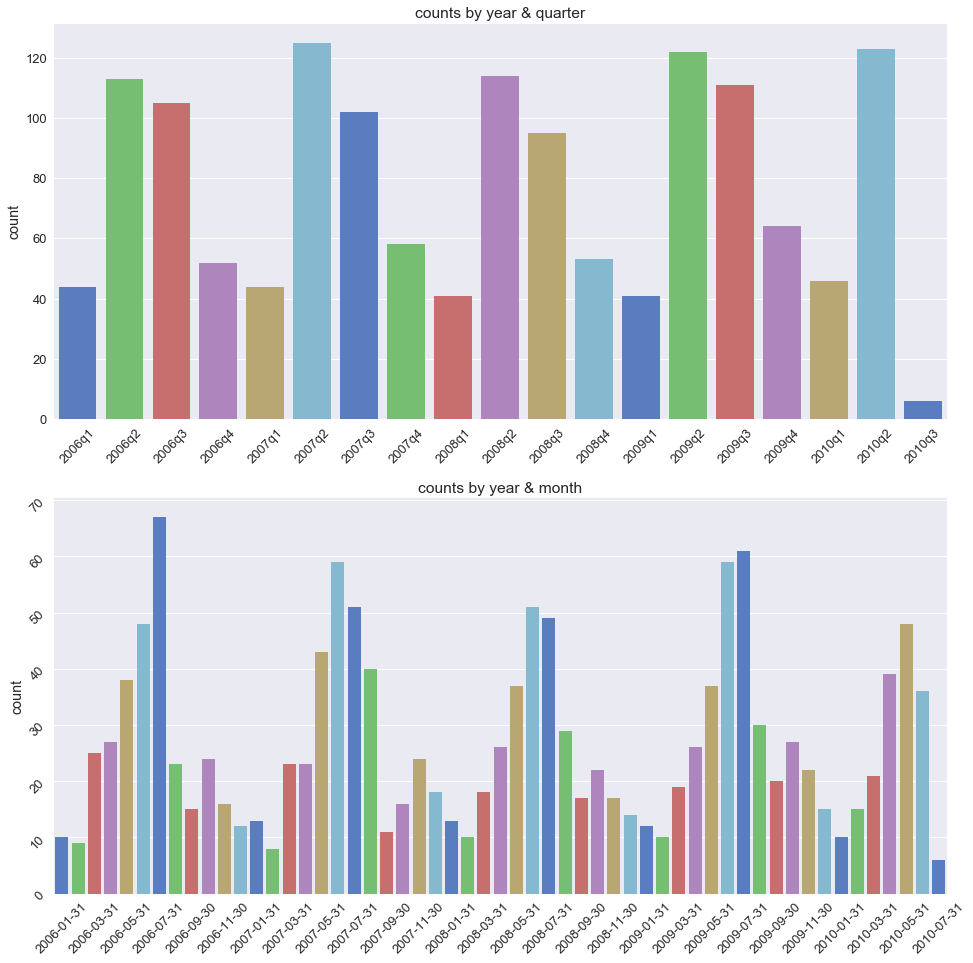

In [49]:
#look at class sizes for new time variables
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
order1 = sorted(train.class_mult.unique())
sns.countplot('class_mult', data=train, order=order1)
ax1.set_xlabel('')
ax1.set_xticklabels(['0 = pre-recession', '1 = during recession', '2 = post-recession'])
plt.title('counts by class')

ax2 = plt.subplot(122)
order2 = sorted(train.yrsold.unique())
sns.countplot('yrsold', data=train, order=order2)
ax2.set_xlabel('')
plt.title('counts by year')

plt.show()

plt.figure(figsize=(16,16))

ax3 = plt.subplot(211)
order3 = sorted(train.yrqtr_sold.unique())
sns.countplot('yrqtr_sold', data=train, order=order3, palette='muted')
ax3.set_xlabel('')
plt.xticks(rotation=45)
plt.title('counts by year & quarter')

ax4 = plt.subplot(212)
order4 = sorted(train.yrmo_sold.unique())
sns.countplot('yrmo_sold', data=train, order=order4, palette='muted')
ax4.set_xlabel('')
for label in ax4.get_xticklabels()[1::2]:
    label.set_visible(False)
ax4.tick_params(labelrotation=45)
ax4.set_xticklabels(xlabels_yrmo)
plt.title('counts by year & month')

plt.show()

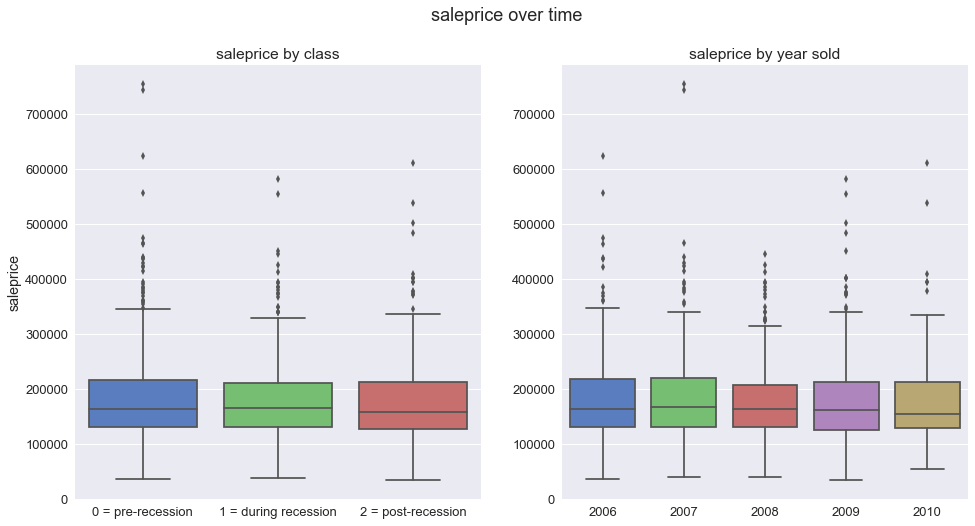

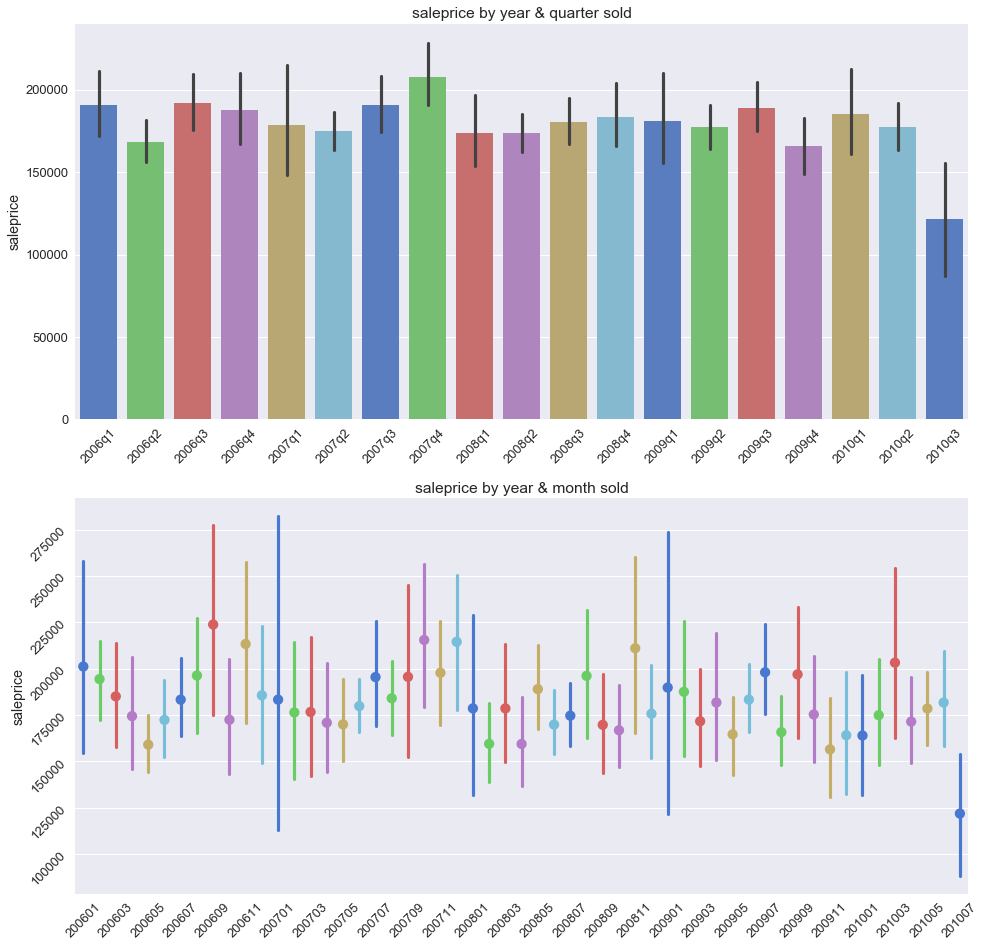

In [12]:
#plot salesprice vs. different time variables
plt.figure(figsize=(16,8))
plt.suptitle('saleprice over time', size=18)

ax1 = plt.subplot(121)
order1 = sorted(train.class_mult.unique())
sns.boxplot(x='class_mult', y='saleprice', data=train, order=order1)
plt.title('saleprice by class')
ax1.set_xlabel('')
ax1.set_xticklabels(['0 = pre-recession', '1 = during recession', '2 = post-recession'])

ax2 = plt.subplot(122)
order2 = sorted(train.yrsold.unique())
sns.boxplot(x='yrsold', y='saleprice', data=train, order=order2)
plt.title('saleprice by year sold')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.show()

plt.figure(figsize=(16,16))
ax3 = plt.subplot(211)
order3 = sorted(train.yrqtr_sold.unique())
sns.barplot(x="yrqtr_sold", y="saleprice", data=train,
            order=order3, palette='muted')
plt.xticks(rotation=45)
ax3.set_xlabel('')
plt.title('saleprice by year & quarter sold')

ax4 = plt.subplot(212)
order4 = sorted(train.yrmo_sold.unique())
sns.pointplot(x='yrmo_sold', y='saleprice', data=train,
              order=order4, palette='muted')
for label in ax4.get_xticklabels()[1::2]:
    label.set_visible(False)
ax4.tick_params(labelrotation=45)
ax4.set_xlabel('')
plt.title('saleprice by year & month sold')

plt.show()

In [13]:
#get some medians and means
labels_yrqtr = sorted(train.yrqtr_sold.unique())
medians_yrqtr = []
means_yrqtr = []

for label in labels_yrqtr:
    medians_yrqtr.append(train[train.yrqtr_sold == label].saleprice.median())
    means_yrqtr.append(train[train.yrqtr_sold == label].saleprice.mean())

labels_yrmo = sorted(train.yrmo_sold.unique())
medians_yrmo = []
means_yrmo = []

for label in labels_yrmo:
    medians_yrmo.append(train[train.yrmo_sold == label].saleprice.median())
    means_yrmo.append(train[train.yrmo_sold == label].saleprice.mean())
    
labels_class = sorted(train.class_mult.unique())
medians_class = []
means_class = []

for label in labels_class:
    medians_class.append(train[train.class_mult == label].saleprice.median())
    means_class.append(train[train.class_mult == label].saleprice.mean())

df_class = pd.DataFrame({'class_labels': labels_class, 'median':medians_class, 'mean':means_class})

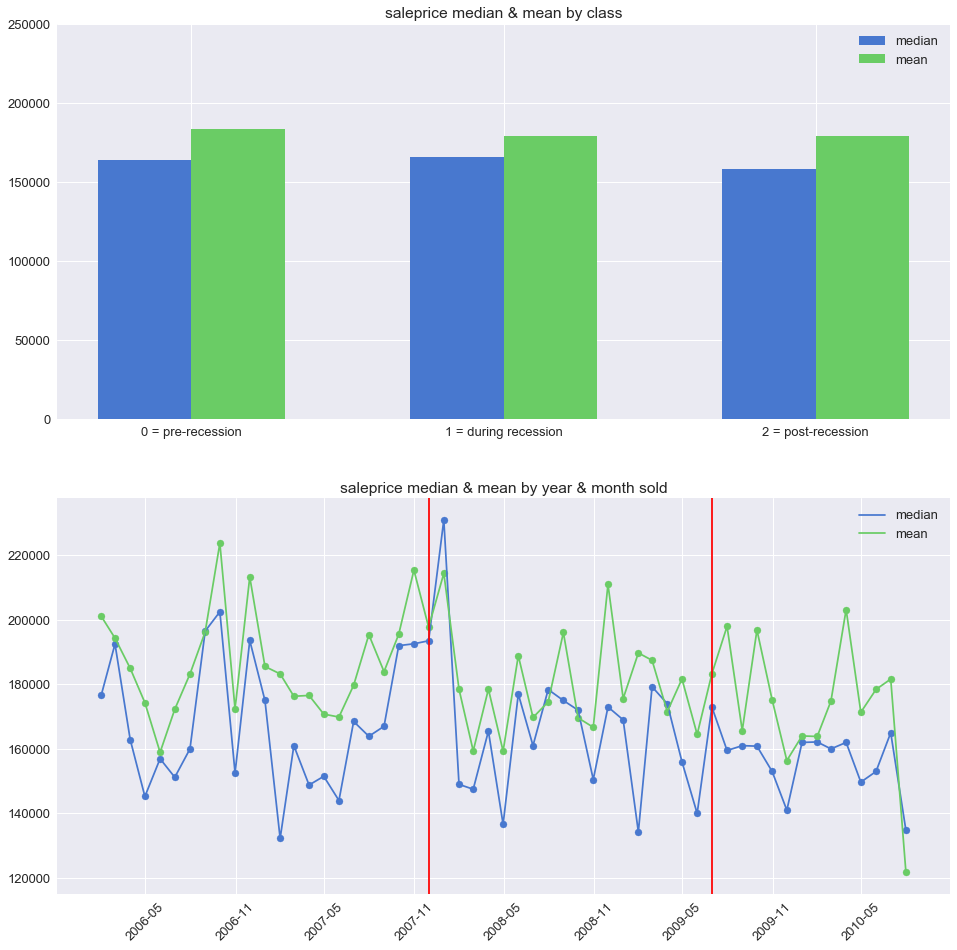

In [20]:
pal = sns.color_palette('muted')

barWidth = 0.3
bars1 = df_class['median']
bars2 = df_class['mean']
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(16,16))

ax1 = plt.subplot(211)
plt.bar(r1, bars1, width=barWidth, color=pal.as_hex()[0], label='median')
plt.bar(r2, bars2, width=barWidth, color=pal.as_hex()[1], label='mean')
plt.xticks([r + 0.15 for r in range(len(bars1))], ['0 = pre-recession', '1 = during recession', '2 = post-recession'])
plt.ylim(0,250000)
plt.legend()
plt.title('saleprice median & mean by class')

ax2 = plt.subplot(212)
plt.plot(xlabels_yrmo, medians_yrmo, label='median')
plt.plot(xlabels_yrmo, means_yrmo, label='mean')
plt.scatter(xlabels_yrmo, medians_yrmo)
plt.scatter(xlabels_yrmo, means_yrmo)
plt.axvline(x='2007-11-30', color='red')
#plt.text(0.83, 0.5, 'recession begins', size=12, transform=ax2.transAxes)
plt.axvline(x='2009-06-30', color='red')
#plt.text(1.98, 0.5, 'recession ends', size=12, transform=ax2.transAxes)
plt.xticks(rotation=45)
plt.title('saleprice median & mean by year & month sold')
plt.legend()

plt.show()

### Below is sloppy/WIP

In [ ]:
#this is gonna be ugly
#seriously figure out a better way than this
def yrmo_dates (n):
    i = 0
    if n['yrmo_sold'] == 200601:
        i = 0
    if n['yrmo_sold'] == 200602:
        i = 1
    if n['yrmo_sold'] == 200603:
        i = 2
    if n['yrmo_sold'] == 200604:
        i = 3
    if n['yrmo_sold'] == 200605:
        i = 4
    if n['yrmo_sold'] == 200606:
        i = 5    
    if n['yrmo_sold'] == 200607:
        i = 6
    if n['yrmo_sold'] == 200608:
        i = 7
    if n['yrmo_sold'] == 200609:
        i = 8
    if n['yrmo_sold'] == 200610:
        i = 9
    if n['yrmo_sold'] == 200611:
        i = 10
    if n['yrmo_sold'] == 200612:
        i = 11
    if n['yrmo_sold'] == 200701:
        i = 12
    if n['yrmo_sold'] == 200702:
        i = 13
    if n['yrmo_sold'] == 200703:
        i = 14
    if n['yrmo_sold'] == 200704:
        i = 15
    if n['yrmo_sold'] == 200705:
        i = 16
    if n['yrmo_sold'] == 200706:
        i = 17    
    if n['yrmo_sold'] == 200707:
        i = 18
    if n['yrmo_sold'] == 200708:
        i = 19
    if n['yrmo_sold'] == 200709:
        i = 20
    if n['yrmo_sold'] == 200710:
        i = 21
    if n['yrmo_sold'] == 200711:
        i = 22
    if n['yrmo_sold'] == 200712:
        i = 23
    if n['yrmo_sold'] == 200801:
        i = 24
    if n['yrmo_sold'] == 200802:
        i = 25
    if n['yrmo_sold'] == 200803:
        i = 26
    if n['yrmo_sold'] == 200804:
        i = 27
    if n['yrmo_sold'] == 200805:
        i = 28
    if n['yrmo_sold'] == 200806:
        i = 29    
    if n['yrmo_sold'] == 200807:
        i = 30
    if n['yrmo_sold'] == 200808:
        i = 31
    if n['yrmo_sold'] == 200809:
        i = 32
    if n['yrmo_sold'] == 200810:
        i = 33
    if n['yrmo_sold'] == 200811:
        i = 34
    if n['yrmo_sold'] == 200812:
        i = 35
    if n['yrmo_sold'] == 200901:
        i = 36
    if n['yrmo_sold'] == 200902:
        i = 37
    if n['yrmo_sold'] == 200903:
        i = 38
    if n['yrmo_sold'] == 200904:
        i = 39
    if n['yrmo_sold'] == 200905:
        i = 40
    if n['yrmo_sold'] == 200906:
        i = 41    
    if n['yrmo_sold'] == 200907:
        i = 42
    if n['yrmo_sold'] == 200908:
        i = 43
    if n['yrmo_sold'] == 200909:
        i = 44
    if n['yrmo_sold'] == 200910:
        i = 45
    if n['yrmo_sold'] == 200911:
        i = 46
    if n['yrmo_sold'] == 200912:
        i = 47
    if n['yrmo_sold'] == 201001:
        i = 48
    if n['yrmo_sold'] == 201002:
        i = 49
    if n['yrmo_sold'] == 201003:
        i = 50
    if n['yrmo_sold'] == 201004:
        i = 51
    if n['yrmo_sold'] == 201005:
        i = 52
    if n['yrmo_sold'] == 201006:
        i = 53    
    if n['yrmo_sold'] == 201007:
        i = 54
    return xlabels_yrmo[i]

In [ ]:
test_df = pd.DataFrame(train['yrmo_sold'].copy())
test_df['yrmo_date'] = test_df.apply(yrmo_dates, axis=1)
test_df['yrmo_date'] = test_df['yrmo_date'].dt.date
test_df['saleprice'] = train['saleprice']
test_df.head()

In [ ]:
pal = sns.color_palette('muted')

barWidth = 0.3
bars1 = df_class['median']
bars2 = df_class['mean']
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(16,16))

plt.subplot(211)
plt.bar(r1, bars1, width=barWidth, color=pal.as_hex()[0], label='median')
plt.bar(r2, bars2, width=barWidth, color=pal.as_hex()[1], label='mean')
plt.xticks([r + 0.15 for r in range(len(bars1))], ['0 = pre-recession', '1 = during recession', '2 = post-recession'])
plt.ylim(0,250000)
plt.legend()
plt.title('saleprice median & mean by class')

plt.subplot(212)
plt.plot(xlabels_yrmo, medians_yrmo, label='median')
plt.plot(xlabels_yrmo, means_yrmo, label='mean')
plt.scatter(xlabels_yrmo, medians_yrmo)
plt.scatter(xlabels_yrmo, means_yrmo)
plt.axvline(x='2007-11-30', color='red')
plt.text(0.83, 0.5, 'recession begins', size=12, transform=ax2.transAxes)
plt.axvline(x='2009-06-30', color='red')
plt.text(1.98, 0.5, 'recession ends', size=12, transform=ax2.transAxes)
plt.xticks(rotation=45)
plt.title('saleprice median & mean by year & month sold')
plt.legend()

plt.show()